In [156]:
import netCDF4
import os
import csv
import datetime as dt
from netCDF4 import num2date
import netCDF4 as nc
from datetime import date
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from pprint import pprint
from matplotlib import pyplot as plt

import praw  # Reddit API
import nltk  # for NLP
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SNTA
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import emoji
import re

pd.set_option('max_columns', 300)
pd.set_option('max_rows', 100)

# Import the companies dataframe and isolate the most searched company

In [2]:
df_searched = pd.read_csv('wallstreetbets_2021.csv')
df_searched

,ticker,overall_rank,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21,2/6/21,2/7/21,2/8/21,2/9/21,2/10/21,2/11/21,2/12/21,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21,4/22/21,4/23/21,4/24/21,4/25/21,4/26/21,4/27/21,4/28/21,4/29/21,4/30/21,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21,5/11/21,5/12/21,5/13/21,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,...,8/5/21,8/6/21,8/7/21,8/8/21,8/9/21,8/10/21,8/11/21,8/12/21,8/13/21,8/14/21,8/15/21,8/16/21,8/17/21,8/18/21,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21,8/29/21,8/30/21,8/31/21,9/1/21,9/2/21,9/3/21,9/4/21,9/5/21,9/6/21,9/7/21,9/8/21,9/9/21,9/10/21,9/11/21,9/12/21,9/13/21,9/14/21,9/15/21,9/16/21,9/17/21,9/18/21,9/19/21,9/20/21,9/21/21,9/22/21,9/23/21,9/24/21,9/25/21,9/26/21,9/27/21,9/28/21,9/29/21,9/30/21,10/1/21,10/2/21,10/3/21,10/4/21,10/5/21,10/6/21,10/7/21,10/8/21,10/9/21,10/10/21,10/11/21,10/12/21,10/13/21,10/14/21,10/15/21,10/16/21,10/17/21,10/18/21,10/19/21,10/20/21,10/21/21,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21,10/29/21,10/30/21,10/31/21,11/1/21,11/2/21,11/3/21,11/4/21,11/5/21,11/6/21,11/7/21,11/8/21,11/9/21,11/10/21,11/11/21,11/12/21,11/13/21,11/14/21,11/15/21,11/16/21,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21,11/30/21,12/1/21,12/2/21,12/3/21,12/4/21,12/5/21,12/6/21,12/7/21,12/8/21,12/9/21,12/10/21,12/11/21,12/12/21,12/13/21,12/14/21,12/15/21,12/16/21,12/17/21,12/18/21,12/19/21,12/20/21,12/21/21,12/22/21,12/23/21,12/24/21,12/25/21,12/26/21,12/27/21,12/28/21,12/29/21,12/30/21,12/31/21,total
0,GME,1,1325,1084,823,1650,1806,1275,1009,1172,479,893,2578,1486,11569,12878,11984,5152,5664,7499,20145,15494,21162,42276,12960,3299,0,0,135136,267231,196168,84438,76651,237511,137697,79970,51677,28334,13263,7795,15552,18246,13294,7997,6090,4089,2230,2077,4726,5993,19384,11884,7215,5804,16361,13759,41281,74924,51603,735,0,0,21384,19515,15300,13009,5682,3950,23671,24066,42347,23557,17953,4503,3657,18113,18198,14470,15820,21791,3350,3243,12463,23115,23290,19685,16966,2823,3282,9391,11102,10521,9602,1924,2428,1222,8720,7121,7705,8029,9606,2752,1791,9960,8526,10595,7554,14242,2631,994,2264,1378,1215,1496,1439,670,490,4868,3113,3603,2276,1953,670,1251,962,711,1861,3191,1235,969,1056,2375,1356,1124,1821,1314,649,302,1623,5302,1499,674,1378,1010,820,823,5259,7296,4927,2718,...,771,247,101,164,1153,251,205,297,290,118,109,347,284,307,379,255,114,84,965,3193,2616,941,730,190,212,1726,964,645,1803,713,355,267,316,883,2068,1155,418,261,326,420,438,467,1026,695,396,132,432,237,229,222,492,294,197,362,551,333,383,275,237,297,404,270,482,459,159,124,207,463,1245,447,396,369,101,207,392,589,207,180,479,1482,157,209,311,232,279,259,144,86,1301,903,1312,1445,492,301,169,350,577,326,309,207,174,107,217,414,261,202,493,228,230,656,1097,272,146,262,81,312,1039,712,383,276,441,364,148,294,241,1280,1106,793,534,158,832,1125,658,263,848,606,273,344,333,359,351,93,274,359,341,220,528,892,817,2607123
1,AMC,2,73,10,10,9,10,10,13,6,2,4,7,11,10,26,256,20,29,321,435,176,86,1117,146,59,0,0,36933,46637,35495,28175,23456,45521,33606,14436,11277,8721,2143,1327,2379,3904,2297,1068,825,331,214,4

In [3]:
print('The most searched company is', df_searched['ticker'].values[0])

The most searched company is GME


# Import post and comment DataFrames

In [134]:
path_posts = r'C:\Users\Panagiotis.Mavritsak\Desktop\Reddit sentiment analysis\downloaded data\summaries\posts\\'
path_comments = r'C:\Users\Panagiotis.Mavritsak\Desktop\Reddit sentiment analysis\downloaded data\summaries\comments\\'

In [142]:
df_sub = pd.read_csv(path_posts+'submissions.csv')
df_sub

,id,url,title,score,upvote_rate,num_comments,created_utc,selftext,DateTime
0,u04so3,https://i.redd.it/3pcb2n5s5ls81.jpg,"“It’s Chess, not Checkers”",35,0.82,7,1.649546e+09,NaN,2022-04-09 23:14:07
1,u04zf6,https://www.reddit.com/gallery/u04zf6,played Tesla options last week. 5k to 17k,381,0.94,75,1.649547e+09,NaN,2022-04-09 23:24:20
2,u050n9,https://i.redd.it/bs42jwrx7ls81.jpg,Apes all over the shop... You’ll be one of the...,77,0.83,29,1.649547e+09,NaN,2022-04-09 23:26:12
3,u051yw,https://gfycat.com/lividliveboa,Wen Moon?,11,0.88,1,1.649547e+09,NaN,2022-04-09 23:28:22
4,u0540r,https://i.redd.it/8zrcapvu8ls81.jpg,S&P Futures Technical Analysis by Adam Mancini,1,1.00,1,1.649547e+09,[deleted],2022-04-09 23:31:21
...,...,...,...,...,...,...,...,...,...
7435,um1y9b,https://imgur.com/4oCp800.gif,Me after going all in oil stocks in mid 2020 b...,1,1.00,0,1.652132e+09,[deleted],2022-05-09 21:33:30
7436,um1yb1,https://i.redd.it/9hdug9j4riy81.jpg,THE HOUSING MARKET IS GOING TO ZERO LIKE IN 20...,1,1.00,1,1.652132e+09,[deleted],2022-05-09 21:33:33
7437,um1zbn,https://i.imgur.com/tFcgybb.jpeg,My portfolio after today,1,1.00,0,1.652132e+09,NaN,2022-05-09 21:34:50
7438,um201i,https://i.redd.it/616q1v6griy81.gif,"Me, knowing nothing about investing, going all...",2,1.00,2,1.652132e+09,NaN,2022-05-09 21:35:42


In [143]:
df_com = pd.read_csv(path_comments+'comments.csv')
df_com

,comment_id,comment_parent_id,comment_body,comment_link_id
0,i43gb7l,u04so3,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,t3_u04so3
1,i43gqan,u04so3,![img](emote|t5_2th52|4271),t3_u04so3
2,i43htzd,u04so3,"It’s Rally’s, not Checkers",t3_u04so3
3,i43h3ho,u04so3,How much did Team Pelosi make on Zoom stock du...,t3_u04so3
4,i43k3y5,i43htzd,Sir this is a Wendy's.,t3_u04so3
...,...,...,...,...
476504,i7yzopa,um1yb1,I am a bot from /r/wallstreetbets. You submitt...,t3_um1yb1
476505,i7yzv6d,um201i,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,t3_um201i
476506,i7yzu0m,um201i,I am a bot from /r/wallstreetbets. You submitt...,t3_um201i
476507,i7yzz1z,um20fo,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,t3_um20fo


### Clean the posts/comments of NaNs, bot comments and User reports
Drop comments if no comment body:

In [144]:
df_com = df_com[df_com.comment_body != np.nan]
df_com.reset_index(inplace=True)
df_com

,index,comment_id,comment_parent_id,comment_body,comment_link_id
0,0,i43gb7l,u04so3,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,t3_u04so3
1,1,i43gqan,u04so3,![img](emote|t5_2th52|4271),t3_u04so3
2,2,i43htzd,u04so3,"It’s Rally’s, not Checkers",t3_u04so3
3,3,i43h3ho,u04so3,How much did Team Pelosi make on Zoom stock du...,t3_u04so3
4,4,i43k3y5,i43htzd,Sir this is a Wendy's.,t3_u04so3
...,...,...,...,...,...
476504,476504,i7yzopa,um1yb1,I am a bot from /r/wallstreetbets. You submitt...,t3_um1yb1
476505,476505,i7yzv6d,um201i,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,t3_um201i
476506,476506,i7yzu0m,um201i,I am a bot from /r/wallstreetbets. You submitt...,t3_um201i
476507,476507,i7yzz1z,um20fo,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,t3_um20fo


In [145]:
df_sub = df_sub[df_sub.title != np.nan]
df_sub.reset_index(inplace=True)
df_sub

,index,id,url,title,score,upvote_rate,num_comments,created_utc,selftext,DateTime
0,0,u04so3,https://i.redd.it/3pcb2n5s5ls81.jpg,"“It’s Chess, not Checkers”",35,0.82,7,1.649546e+09,NaN,2022-04-09 23:14:07
1,1,u04zf6,https://www.reddit.com/gallery/u04zf6,played Tesla options last week. 5k to 17k,381,0.94,75,1.649547e+09,NaN,2022-04-09 23:24:20
2,2,u050n9,https://i.redd.it/bs42jwrx7ls81.jpg,Apes all over the shop... You’ll be one of the...,77,0.83,29,1.649547e+09,NaN,2022-04-09 23:26:12
3,3,u051yw,https://gfycat.com/lividliveboa,Wen Moon?,11,0.88,1,1.649547e+09,NaN,2022-04-09 23:28:22
4,4,u0540r,https://i.redd.it/8zrcapvu8ls81.jpg,S&P Futures Technical Analysis by Adam Mancini,1,1.00,1,1.649547e+09,[deleted],2022-04-09 23:31:21
...,...,...,...,...,...,...,...,...,...,...
7435,7435,um1y9b,https://imgur.com/4oCp800.gif,Me after going all in oil stocks in mid 2020 b...,1,1.00,0,1.652132e+09,[deleted],2022-05-09 21:33:30
7436,7436,um1yb1,https://i.redd.it/9hdug9j4riy81.jpg,THE HOUSING MARKET IS GOING TO ZERO LIKE IN 20...,1,1.00,1,1.652132e+09,[deleted],2022-05-09 21:33:33
7437,7437,um1zbn,https://i.imgur.com/tFcgybb.jpeg,My portfolio after today,1,1.00,0,1.652132e+09,NaN,2022-05-09 21:34:50
7438,7438,um201i,https://i.redd.it/616q1v6griy81.gif,"Me, knowing nothing about investing, going all...",2,1.00,2,1.652132e+09,NaN,2022-05-09 21:35:42


Drop comments from the subreddit bot and User Reports:

In [146]:
df_com = df_com[ df_com['comment_body'].str.contains('I am a bot') == False ]  # why ~ not work?
df_com.reset_index(inplace=True)
df_com.drop(['level_0', 'index'], axis=1, inplace=True)

df_com = df_com[ df_com['comment_body'].str.contains("User Report") == False ]  # why ~ not work?
df_com.reset_index(inplace=True)
df_com.drop(['index'], axis=1, inplace=True)

df_com

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,comment_id,comment_parent_id,comment_body,comment_link_id
0,i43gqan,u04so3,![img](emote|t5_2th52|4271),t3_u04so3
1,i43htzd,u04so3,"It’s Rally’s, not Checkers",t3_u04so3
2,i43h3ho,u04so3,How much did Team Pelosi make on Zoom stock du...,t3_u04so3
3,i43k3y5,i43htzd,Sir this is a Wendy's.,t3_u04so3
4,i43ko1f,i43k3y5,Sir this is a Wendys/ Chili-N-Such express com...,t3_u04so3
...,...,...,...,...
464082,i7yznrt,i7yzf9o,Start with $70,t3_um1wuv
464083,i7yzvln,i7yzf9o,If they bought 28 shares of Rivian at open (~$...,t3_um1wuv
464084,i7yzykp,i7yzjan,This must be the only correct answer. I thoug...,t3_um1wuv
464085,i7yzh6c,um1xpa,Release the ponzi,t3_um1xpa


Drop removed comments:

In [125]:
# df_com = df_com[ df_com['comment_body'].str.contains("[removed]") == False ]  # why ~ not work?
# df_com.reset_index(inplace=True)
# df_com.drop(['index'], axis=1, inplace=True)
# df_com

In [141]:
# df_com = df_com[ df_com['comment_body'].str.contains("[deleted]") == False ]  # why ~ not work?
# df_com.reset_index(inplace=True)
# df_com.drop(['index'], axis=1, inplace=True)
# df_com

Drop images? Have to review again:

In [147]:
df_com = df_com[ df_com['comment_body'].str.contains("![img]") == False ]  # why ~ not work?
df_com.reset_index(inplace=True)
df_com.drop(['index'], axis=1, inplace=True)
df_com

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,comment_id,comment_parent_id,comment_body,comment_link_id
0,i43gqan,u04so3,![img](emote|t5_2th52|4271),t3_u04so3
1,i43htzd,u04so3,"It’s Rally’s, not Checkers",t3_u04so3
2,i43h3ho,u04so3,How much did Team Pelosi make on Zoom stock du...,t3_u04so3
3,i43k3y5,i43htzd,Sir this is a Wendy's.,t3_u04so3
4,i43ko1f,i43k3y5,Sir this is a Wendys/ Chili-N-Such express com...,t3_u04so3
...,...,...,...,...
464031,i7yznrt,i7yzf9o,Start with $70,t3_um1wuv
464032,i7yzvln,i7yzf9o,If they bought 28 shares of Rivian at open (~$...,t3_um1wuv
464033,i7yzykp,i7yzjan,This must be the only correct answer. I thoug...,t3_um1wuv
464034,i7yzh6c,um1xpa,Release the ponzi,t3_um1xpa


In [190]:
for i in range(len(df_com)):
#     if df_com['comment_body'].str.contains("![img]").iloc[i]:
    print(df_com.comment_body.iloc[i])

### The following process is to clean the posts/comments by:
1. Removing Emojis
2. Removing links etc.

### Apart from that, we will focus on:
1. Removing stopwords
2. Lemmatizing

which will be done by breaking down each comment body to its individual words in a seperate column

In [175]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|http\S+')  # to break down text
# nlp = en_core_web_sm.load()
nltk.download('stopwords')
cachedStopWords = stopwords.words("english")  # to remove neutral words
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()  # to bring words back to the root word

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Panagiotis.Mavritsak\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Panagiotis.Mavritsak\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [187]:
df_sub['list'] = df_sub['title']

for i in range(len(df_sub)):
#     print(df_sub.title.iloc[i])
    
    # remove emojis
    df_sub.title.iloc[i] = emoji.replace_emoji(df_sub.title.iloc[i], replace=' ')
    
    # remove links
    df_sub.title.iloc[i] = re.sub(r'http\S+', '', df_sub.title.iloc[i])
    
    # remove stopwords from the new column before breaking it down
    df_sub.list.iloc[i] = ' '.join([word for word in df_sub.list.iloc[i].split() if word not in cachedStopWords])
    # tokenize new column
    df_sub.list.iloc[i] = tokenizer.tokenize(df_sub.list.iloc[i])
    # only lower case letters
    df_sub.list.iloc[i] = [word.lower() for word in df_sub.list.iloc[i]]
    # bring each word on the list back to its root word
    df_sub.list.iloc[i] = ([lemmatizer.lemmatize(w) for w in df_sub.list.iloc[i]])
    
    # let's compare the different columns
#     print(df_sub.title.iloc[i])
#     print(df_sub.list.iloc[i])
#     print('**'*20)
#     print(' ')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [196]:
df_sub['merged_list'] = [' '.join(map(str, l)) for l in df_sub['list']]
df_sub

,index,id,url,title,score,upvote_rate,num_comments,created_utc,selftext,DateTime,compound,NLTK_label,list,j,merged_list
0,0,u04so3,https://i.redd.it/3pcb2n5s5ls81.jpg,"“It’s Chess, not Checkers”",35,0.82,7,1.649546e+09,NaN,2022-04-09 23:14:07,0,Neutral,"[it, s, chess, checker]",it s chess checker,it s chess checker
1,1,u04zf6,https://www.reddit.com/gallery/u04zf6,played Tesla options last week. 5k to 17k,381,0.94,75,1.649547e+09,NaN,2022-04-09 23:24:20,0,Neutral,"[played, tesla, option, last, week, 5k, 17k]",played tesla option last week 5k 17k,played tesla option last week 5k 17k
2,2,u050n9,https://i.redd.it/bs42jwrx7ls81.jpg,Apes all over the shop... You’ll be one of the...,77,0.83,29,1.649547e+09,NaN,2022-04-09 23:26:12,0,Neutral,"[ape, shop, you, ll, one, sooner, later]",ape shop you ll one sooner later,ape shop you ll one sooner later
3,3,u051yw,https://gfycat.com/lividliveboa,Wen Moon?,11,0.88,1,1.649547e+09,NaN,2022-04-09 23:28:22,0,Neutral,"[wen, moon]",wen moon,wen moon
4,4,u0540r,https://i.redd.it/8zrcapvu8ls81.jpg,S&P Futures Technical Analysis by Adam Mancini,1,1.00,1,1.649547e+09,[deleted],2022-04-09 23:31:21,0,Neutral,"[s, p, future, technical, analysis, adam, manc...",s p future technical analysis adam mancini,s p future technical analysis adam mancini
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,7435,um1y9b,https://imgur.com/4oCp800.gif,Me after going all in oil stocks in mid 2020 b...,1,1.00,0,1.652132e+09,[deleted],2022-05-09 21:33:30,0,Neutral,"[me, going, oil, stock, mid, 2020, oil, go, ba...",me going oil stock mid 2020 oil go back virus ...,me going oil stock mid 2020 oil go back virus ...
7436,7436,um1yb1,https://i.redd.it/9hdug9j4riy81.jpg,THE HOUSING MARKET IS GOING TO ZERO LIKE IN 20...,1,1.00,1,1.652132e+09,[deleted],2022-05-09 21:33:33,0,Neutral,"[the, housing, market, is, going, to, zero, li...",the housing market is going to zero like in 20...,the housing market is going to zero like in 20...
7437,7437,um1zbn,https://i.imgur.com/tFcgybb.jpeg,My portfolio after today,1,1.00,0,1.652132e+09,NaN,2022-05-09 21:34:50,0,Neutral,"[my, portfolio, today]",my portfolio today,my portfolio today
7438,7438,um201i,https://i.redd.it/616q1v6griy81.gif,"Me, knowing nothing about investing, going all...",2,1.00,2,1.652132e+09,NaN,2022-05-09 21:35:42,0,Neutral,"[me, knowing, nothing, investing, going, oil, ...",me knowing nothing investing going oil stock m...,me knowing nothing investing going oil stock m...


In [178]:
df_com['list'] = df_com['comment_body']

for i in range(len(df_com)):
#     print(df_com.comment_body.iloc[i])
    
    # remove emojis
    df_com.comment_body.iloc[i] = emoji.replace_emoji(df_com.comment_body.iloc[i], replace=' ')
    
    # remove links
    df_com.comment_body.iloc[i] = re.sub(r'http\S+', '', df_com.comment_body.iloc[i])
    
    # remove stopwords from the new column before breaking it down
    df_com.list.iloc[i] = ' '.join([word for word in df_com.list.iloc[i].split() if word not in cachedStopWords])
    # tokenize new column
    df_com.list.iloc[i] = tokenizer.tokenize(df_com.list.iloc[i])
    # only lower case letters
    df_com.list.iloc[i] = [word.lower() for word in df_com.list.iloc[i]]
    # bring each word on the list back to its root word
    df_com.list.iloc[i] = ([lemmatizer.lemmatize(w) for w in df_com.list.iloc[i]])
    
    # let's compare the different columns
#     print(df_com.comment_body.iloc[i])
#     print(df_com.list.iloc[i])
#     print('**'*20)
#     print(' ')

C:\Users\PANAGI~1.MAV\AppData\Local\Temp/ipykernel_35504/2918552392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_com['list'] = df_com['comment_body']
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


KeyboardInterrupt: 

In [197]:
df_com['merged_list'] = [' '.join(map(str, l)) for l in df_com['list']]
df_com

C:\Users\PANAGI~1.MAV\AppData\Local\Temp/ipykernel_35504/1671787904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_com['merged_list'] = [' '.join(map(str, l)) for l in df_com['list']]


,comment_id,comment_parent_id,comment_body,comment_link_id,list,merged_list
0,i43gqan,u04so3,![img](emote|t5_2th52|4271),t3_u04so3,"[img, emote, t5_2th52, 4271]",img emote t5_2th52 4271
1,i43htzd,u04so3,"It’s Rally’s, not Checkers",t3_u04so3,"[it, s, rally, s, checker]",it s rally s checker
2,i43h3ho,u04so3,How much did Team Pelosi make on Zoom stock du...,t3_u04so3,"[how, much, team, pelosi, make, zoom, stock, l...",how much team pelosi make zoom stock lockdown
3,i43k3y5,i43htzd,Sir this is a Wendy's.,t3_u04so3,"[sir, wendy, s]",sir wendy s
4,i43ko1f,i43k3y5,Sir this is a Wendys/ Chili-N-Such express com...,t3_u04so3,"[sir, wendys, chili, n, such, express, combo, ...",sir wendys chili n such express combo can scoo...
...,...,...,...,...,...,...
49995,i4wncm4,i4wmwk5,[deleted],t3_u4mdjd,[deleted],deleted
49996,i4wzakt,i4wyyon,"Even if you expand medicare, you would need to...",t3_u4mdjd,"[even, expand, medicare, would, need, cap, pri...",even expand medicare would need cap price othe...
49997,i51d7ji,i51cle4,"> ""it doubles every year because 1000 per year...",t3_u4mdjd,"[it, double, every, year, 1000, per, year, 40,...",it double every year 1000 per year 40 year 40 ...
49998,i4wnqh9,i4wncm4,Thank you for pointing out the importance of d...,t3_u4mdjd,"[thank, pointing, importance, diversification,...",thank pointing importance diversification over...


Pie plot of unique words - too many to run for now

In [ ]:
# df_com['list'].explode().value_counts().plot.pie(figsize=(16,16));

In [ ]:
# list_of_words = df_com['list'].to_list()
# list_of_words

In [ ]:
# unique_words = sorted(set(w for d in list_of_words for s in d for w in s))
# unique_words

# Check the mentions of the company tickers in the headline
First define the number of companies (top for 2021) to be included in the analysis

In [8]:
num_companies = 50 # top num_companies to be included

In [9]:
for index in range(num_companies):
#     print('Running for: ', df_searched['ticker'].values[index])
    df_sub[df_searched['ticker'].values[index]] = False
    for i in range(len(df_sub)):
        if df_searched['ticker'].values[index] in df_sub['title'][i]:
            df_sub[df_searched['ticker'].values[index]][i] = True
df_sub

C:\Users\PANAGI~1.MAV\AppData\Local\Temp/ipykernel_35504/1019327612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[df_searched['ticker'].values[index]][i] = True


,id,url,title,score,upvote_rate,num_comments,created_utc,selftext,DateTime,GME,AMC,BB,TSLA,PLTR,SPY,NOK,CLOV,RKT,WISH,AAPL,AMD,SNDL,SLV,NIO,UWMC,TLRY,MVIS,BABA,SPCE,AMZN,CRSR,SOFI,NVDA,CLNE,F,WKHS,APHA,CLF,FB,QQQ,MSFT,VIX,RIDE,NFLX,MNMD,SDC,COIN,VW,ICLN,DKNG,RBLX,GOEV,NAKD,VIAC,GM,PLUG,ARK,LCID,BBBY
0,u04so3,https://i.redd.it/3pcb2n5s5ls81.jpg,"“It’s Chess, not Checkers”",35,0.82,7,1.649546e+09,NaN,2022-04-09 23:14:07,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,u04zf6,https://www.reddit.com/gallery/u04zf6,played Tesla options last week. 5k to 17k,381,0.94,75,1.649547e+09,NaN,2022-04-09 23:24:20,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,u050n9,https://i.redd.it/bs42jwrx7ls81.jpg,Apes all over the shop... You’ll be one of the...,77,0.83,29,1.649547e+09,NaN,2022-04-09 23:26:12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,u051yw,https://gfycat.com/lividliveboa,Wen Moon?,11,0.88,1,1.649547e+09,NaN,2022-04-09 23:28:22,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,u0540r,https://i.redd.it/8zrcapvu8ls81.jpg,S&P Futures Technical Analysis by Adam Mancini,1,1.00,1,1.649547e+09,[deleted],2022-04-09 23:31:21,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,um1y9b,https://imgur.com/4oCp800.gif,Me after going all in oil stocks in mid 2020 b...,1,1.00,0,1.652132e+09,[deleted],2022-05-09 21:33:30,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7436,um1yb1,https://i.redd.it/9hdug9j4riy81.jpg,THE HOUSING MARKET IS GOING TO ZERO LIKE IN 20...,1,1.00,1,1.652132e+09,[deleted],2022-05-09 21:33:33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
7437,um1zbn,https://i.imgur.com/tFcgybb.jpeg,My portfolio after today,1,1.00,0,1.652132e+09,NaN,2022-05-09 21:34:50,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7438,um2

Let's check the percentage of mentions of the aforementioned companies in the headlines:

In [10]:
for index in range(num_companies):
    per = df_sub[df_searched['ticker'].values[index]].sum() * 100 / len(df_sub)
    print(df_searched['ticker'].values[index], f'is mentioned in {per:.2f}% of the headlines.')
    print(' ')

GME is mentioned in 1.13% of the headlines.
 
AMC is mentioned in 0.75% of the headlines.
 
BB is mentioned in 0.56% of the headlines.
 
TSLA is mentioned in 0.55% of the headlines.
 
PLTR is mentioned in 0.20% of the headlines.
 
SPY is mentioned in 1.14% of the headlines.
 
NOK is mentioned in 0.03% of the headlines.
 
CLOV is mentioned in 0.05% of the headlines.
 
RKT is mentioned in 0.04% of the headlines.
 
WISH is mentioned in 0.16% of the headlines.
 
AAPL is mentioned in 0.08% of the headlines.
 
AMD is mentioned in 0.42% of the headlines.
 
SNDL is mentioned in 0.08% of the headlines.
 
SLV is mentioned in 0.01% of the headlines.
 
NIO is mentioned in 0.16% of the headlines.
 
UWMC is mentioned in 0.03% of the headlines.
 
TLRY is mentioned in 0.05% of the headlines.
 
MVIS is mentioned in 0.00% of the headlines.
 
BABA is mentioned in 0.09% of the headlines.
 
SPCE is mentioned in 0.15% of the headlines.
 
AMZN is mentioned in 0.27% of the headlines.
 
CRSR is mentioned in 0.

Same process for comments:

In [11]:
for index in range(num_companies):
#     print('Running for: ', df_searched['ticker'].values[index])
    df_com[df_searched['ticker'].values[index]] = False
    for i in range(len(df_com)):
        if df_com['comment_body'].iloc[i] is not np.nan:
            if df_searched['ticker'].values[index] in df_com['comment_body'][i]:
                df_com[df_searched['ticker'].values[index]][i] = True
df_com

C:\Users\PANAGI~1.MAV\AppData\Local\Temp/ipykernel_35504/3069994104.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_com[df_searched['ticker'].values[index]][i] = True


,index,comment_id,comment_parent_id,comment_body,comment_link_id,GME,AMC,BB,TSLA,PLTR,SPY,NOK,CLOV,RKT,WISH,AAPL,AMD,SNDL,SLV,NIO,UWMC,TLRY,MVIS,BABA,SPCE,AMZN,CRSR,SOFI,NVDA,CLNE,F,WKHS,APHA,CLF,FB,QQQ,MSFT,VIX,RIDE,NFLX,MNMD,SDC,COIN,VW,ICLN,DKNG,RBLX,GOEV,NAKD,VIAC,GM,PLUG,ARK,LCID,BBBY
0,0,i43gb7l,u04so3,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,t3_u04so3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,1,i43gqan,u04so3,![img](emote|t5_2th52|4271),t3_u04so3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,i43htzd,u04so3,"It’s Rally’s, not Checkers",t3_u04so3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,i43h3ho,u04so3,How much did Team Pelosi make on Zoom stock du...,t3_u04so3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,4,i43k3y5,i43htzd,Sir this is a Wendy's.,t3_u04so3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476504,476504,i7yzopa,um1yb1,I am a bot from /r/wallstreetbets. You submitt...,t3_um1yb1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
476505,476505,i7yzv6d,um201i,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,t3_um201i,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
476506,476506,i7yzu0m,um201i,I am a bot from /r/wallstreetbets. You submitt...,t3_um201i,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
476507,476507,i7yzz1z,um20fo,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,t3_um20fo,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [12]:
for index in range(num_companies):
    per = df_com[df_searched['ticker'].values[index]].sum() * 100 / len(df_com)
    print(df_searched['ticker'].values[index], f'is mentioned in {per:.2f}% of the comments.')
    print(' ')

GME is mentioned in 0.56% of the comments.
 
AMC is mentioned in 0.21% of the comments.
 
BB is mentioned in 0.10% of the comments.
 
TSLA is mentioned in 0.60% of the comments.
 
PLTR is mentioned in 0.16% of the comments.
 
SPY is mentioned in 1.44% of the comments.
 
NOK is mentioned in 0.01% of the comments.
 
CLOV is mentioned in 0.03% of the comments.
 
RKT is mentioned in 0.01% of the comments.
 
WISH is mentioned in 0.07% of the comments.
 
AAPL is mentioned in 0.13% of the comments.
 
AMD is mentioned in 0.55% of the comments.
 
SNDL is mentioned in 0.01% of the comments.
 
SLV is mentioned in 0.01% of the comments.
 
NIO is mentioned in 0.06% of the comments.
 
UWMC is mentioned in 0.00% of the comments.
 
TLRY is mentioned in 0.03% of the comments.
 
MVIS is mentioned in 0.00% of the comments.
 
BABA is mentioned in 0.04% of the comments.
 
SPCE is mentioned in 0.02% of the comments.
 
AMZN is mentioned in 0.14% of the comments.
 
CRSR is mentioned in 0.02% of the comments.


### Next feature to be generated is to measure the number of ticker mentions in the comment section  for each post 

In [13]:
for index in range(num_companies):  # set column initially to 0
    df_sub[df_searched['ticker'].values[index]+'_comments'] = 0

for i in range(len(df_sub)):
#     print('Running row: ', i)
    temp_df = pd.DataFrame()
    temp_df = df_com[ df_com['comment_parent_id'] == df_sub['id'].iloc[i] ]
    
    for index in range(num_companies):
        if len(temp_df) > 0:
            df_sub[df_searched['ticker'].values[index]+'_comments'].iloc[i] = temp_df[df_searched['ticker'].values[index]].sum()

C:\Users\PANAGI~1.MAV\AppData\Local\Temp/ipykernel_35504/201411414.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sub[df_searched['ticker'].values[index]+'_comments'] = 0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
for index in range(num_companies):
    inst = df_sub[df_searched['ticker'].values[index]+'_comments'].sum()
    print(df_searched['ticker'].values[index], f'is mentioned in {inst:.0f} comments in total.')
    print(' ')

GME is mentioned in 1475 comments in total.
 
AMC is mentioned in 578 comments in total.
 
BB is mentioned in 333 comments in total.
 
TSLA is mentioned in 2008 comments in total.
 
PLTR is mentioned in 579 comments in total.
 
SPY is mentioned in 5274 comments in total.
 
NOK is mentioned in 25 comments in total.
 
CLOV is mentioned in 110 comments in total.
 
RKT is mentioned in 40 comments in total.
 
WISH is mentioned in 210 comments in total.
 
AAPL is mentioned in 402 comments in total.
 
AMD is mentioned in 2033 comments in total.
 
SNDL is mentioned in 42 comments in total.
 
SLV is mentioned in 16 comments in total.
 
NIO is mentioned in 219 comments in total.
 
UWMC is mentioned in 15 comments in total.
 
TLRY is mentioned in 99 comments in total.
 
MVIS is mentioned in 2 comments in total.
 
BABA is mentioned in 134 comments in total.
 
SPCE is mentioned in 57 comments in total.
 
AMZN is mentioned in 454 comments in total.
 
CRSR is mentioned in 69 comments in total.
 
SOFI

# Check the key word mentions
First define the list of keywords of interest to be assessed

In [15]:
bearish = ['put', 'buy']
bullish = ['call', 'sell']
keywords = bearish + bullish
keywords  # bearish and bullish keywords

['put', 'buy', 'call', 'sell']

In [16]:
for word in keywords:  # check the instances of keywords
    df_sub[word+'_instance'] = False
    for i in range(len(df_sub)):
            if ( word in df_sub['title'][i] ) | ( word+'s' in df_sub['title'][i] ):
                df_sub[word+'_instance'][i] = True
# df_sub

C:\Users\PANAGI~1.MAV\AppData\Local\Temp/ipykernel_35504/3724832868.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sub[word+'_instance'] = False
C:\Users\PANAGI~1.MAV\AppData\Local\Temp/ipykernel_35504/3724832868.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[word+'_instance'][i] = True


In [17]:
for word in keywords:
    per = df_sub[word+'_instance'].sum() * 100 / len(df_sub)
    print(f'Keyword \033[1m{word}\033[0m is mentioned in {per:.2f}% of the headlines.')
    print(' ')

Keyword put is mentioned in 2.26% of the headlines.
 
Keyword buy is mentioned in 3.84% of the headlines.
 
Keyword call is mentioned in 2.84% of the headlines.
 
Keyword sell is mentioned in 1.47% of the headlines.
 


Same process for comments:

In [18]:
for word in keywords:  # check the instances of keywords
    df_com[word+'_instance'] = False
    for i in range(len(df_com)):
        if df_com['comment_body'].iloc[i] is not np.nan:
            if ( word in df_com['comment_body'][i] ) | ( word+'s' in df_com['comment_body'][i] ):
                df_com[word+'_instance'][i] = True
# df_com

C:\Users\PANAGI~1.MAV\AppData\Local\Temp/ipykernel_35504/676484017.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_com[word+'_instance'][i] = True


In [19]:
for word in keywords:
    per = df_com[word+'_instance'].sum() * 100 / len(df_com)
    print(f'Keyword \033[1m{word}\033[0m is mentioned in {per:.2f}% of the comments.')
    print(' ')

Keyword put is mentioned in 3.94% of the comments.
 
Keyword buy is mentioned in 4.25% of the comments.
 
Keyword call is mentioned in 5.56% of the comments.
 
Keyword sell is mentioned in 2.14% of the comments.
 


### Measure the number of keyword mentions in the comment section for each post 

In [20]:
for word in keywords:  # set initial collumns to 0
    df_sub[word+'_comments'] = 0

for i in range(len(df_sub)):
#     print('Running row: ', i)
    temp_df = pd.DataFrame()
    temp_df = df_com[ df_com['comment_parent_id'] == df_sub['id'].iloc[i] ]
    
    for word in keywords:
        if len(temp_df) > 0:
            df_sub[word+'_comments'].iloc[i] = temp_df[word+'_instance'].sum()  

C:\Users\PANAGI~1.MAV\AppData\Local\Temp/ipykernel_35504/3787196196.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sub[word+'_comments'] = 0


In [21]:
df_sub

,id,url,title,score,upvote_rate,num_comments,created_utc,selftext,DateTime,GME,AMC,BB,TSLA,PLTR,SPY,NOK,CLOV,RKT,WISH,AAPL,AMD,SNDL,SLV,NIO,UWMC,TLRY,MVIS,BABA,SPCE,AMZN,CRSR,SOFI,NVDA,CLNE,F,WKHS,APHA,CLF,FB,QQQ,MSFT,VIX,RIDE,NFLX,MNMD,SDC,COIN,VW,ICLN,DKNG,RBLX,GOEV,NAKD,VIAC,GM,PLUG,ARK,LCID,BBBY,GME_comments,AMC_comments,BB_comments,TSLA_comments,PLTR_comments,SPY_comments,NOK_comments,CLOV_comments,RKT_comments,WISH_comments,AAPL_comments,AMD_comments,SNDL_comments,SLV_comments,NIO_comments,UWMC_comments,TLRY_comments,MVIS_comments,BABA_comments,SPCE_comments,AMZN_comments,CRSR_comments,SOFI_comments,NVDA_comments,CLNE_comments,F_comments,WKHS_comments,APHA_comments,CLF_comments,FB_comments,QQQ_comments,MSFT_comments,VIX_comments,RIDE_comments,NFLX_comments,MNMD_comments,SDC_comments,COIN_comments,VW_comments,ICLN_comments,DKNG_comments,RBLX_comments,GOEV_comments,NAKD_comments,VIAC_comments,GM_comments,PLUG_comments,ARK_comments,LCID_comments,BBBY_comments,put_instance,buy_instance,call_instance,sell_instance,put_comments,buy_comments,call_comments,sell_comments
0,u04so3,https://i.redd.it/3pcb2n5s5ls81.jpg,"“It’s Chess, not Checkers”",35,0.82,7,1.649546e+09,NaN,2022-04-09 23:14:07,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,0,0,0,0
1,u04zf6,https://www.reddit.com/gallery/u04zf6,played Tesla options last week. 5k to 17k,381,0.94,75,1.649547e+09,NaN,2022-04-09 23:24:20,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,4,1,3,1
2,u050n9,https://i.redd.it/bs42jwrx7ls81.jpg,Apes all over the shop... You’ll be one of the...,77,0.83,29,1.649547e+09,NaN,2022-04-09 23:26:12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,1,0,1,0
3,u051yw,https://gfycat.com/lividliveboa,Wen Moon?,11,0.88,1,1.649547e+09,NaN,2022-04-09 23:28:22,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,0,0,0,0
4,u0540r,https://i.redd.it/8zrcapvu8ls81.jpg,S&P Futures Technical Analysis by Adam Mancini,1,1.00,1,1.649547e+09,[deleted],2022-04-09 23:31:21,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [22]:
for word in keywords:
    inst = df_sub[word+'_comments'].sum()
    print(f'Keyword \033[1m{word}\033[0m is mentioned in {inst:.0f} comments in total.')
    print(' ')

Keyword put is mentioned in 10823 comments in total.
 
Keyword buy is mentioned in 10809 comments in total.
 
Keyword call is mentioned in 14746 comments in total.
 
Keyword sell is mentioned in 4951 comments in total.
 


# Sentiments analysis of headlines/comments using NLTK

### maybe should be run for individual words? - could be tested for shorter samples

First set threshold for Positive/Negative classification:

In [198]:
thr = 0.25

In [199]:
analyzer = SNTA()  # analyzer of sentiments

# df_sub['neg'] = 0
# df_sub['pos'] = 0
# df_sub['neu'] = 0
df_sub['compound'] = 0
df_sub['NLTK_label'] = 'Neutral'

for i in range(len(df_sub)):
    sntm_score = analyzer.polarity_scores(df_sub['merged_list'][i])
#     df_sub['neg'].iloc[i]      = sntm_score['neg']
#     df_sub['pos'].iloc[i]      = sntm_score['pos']
#     df_sub['neu'].iloc[i]      = sntm_score['neu']
    df_sub['compound'].iloc[i] = sntm_score['compound']

    if df_sub['compound'].iloc[i] > thr:
        df_sub['NLTK_label'].iloc[i] = 'Positive'
    elif df_sub['compound'].iloc[i] < -thr:
        df_sub['NLTK_label'].iloc[i] = 'Negative'
          
df_sub

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,index,id,url,title,score,upvote_rate,num_comments,created_utc,selftext,DateTime,compound,NLTK_label,list,j,merged_list
0,0,u04so3,https://i.redd.it/3pcb2n5s5ls81.jpg,"“It’s Chess, not Checkers”",35,0.82,7,1.649546e+09,NaN,2022-04-09 23:14:07,0.0000,Neutral,"[it, s, chess, checker]",it s chess checker,it s chess checker
1,1,u04zf6,https://www.reddit.com/gallery/u04zf6,played Tesla options last week. 5k to 17k,381,0.94,75,1.649547e+09,NaN,2022-04-09 23:24:20,0.3400,Positive,"[played, tesla, option, last, week, 5k, 17k]",played tesla option last week 5k 17k,played tesla option last week 5k 17k
2,2,u050n9,https://i.redd.it/bs42jwrx7ls81.jpg,Apes all over the shop... You’ll be one of the...,77,0.83,29,1.649547e+09,NaN,2022-04-09 23:26:12,0.0000,Neutral,"[ape, shop, you, ll, one, sooner, later]",ape shop you ll one sooner later,ape shop you ll one sooner later
3,3,u051yw,https://gfycat.com/lividliveboa,Wen Moon?,11,0.88,1,1.649547e+09,NaN,2022-04-09 23:28:22,0.0000,Neutral,"[wen, moon]",wen moon,wen moon
4,4,u0540r,https://i.redd.it/8zrcapvu8ls81.jpg,S&P Futures Technical Analysis by Adam Mancini,1,1.00,1,1.649547e+09,[deleted],2022-04-09 23:31:21,0.0000,Neutral,"[s, p, future, technical, analysis, adam, manc...",s p future technical analysis adam mancini,s p future technical analysis adam mancini
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,7435,um1y9b,https://imgur.com/4oCp800.gif,Me after going all in oil stocks in mid 2020 b...,1,1.00,0,1.652132e+09,[deleted],2022-05-09 21:33:30,0.0000,Neutral,"[me, going, oil, stock, mid, 2020, oil, go, ba...",me going oil stock mid 2020 oil go back virus ...,me going oil stock mid 2020 oil go back virus ...
7436,7436,um1yb1,https://i.redd.it/9hdug9j4riy81.jpg,THE HOUSING MARKET IS GOING TO ZERO LIKE IN 20...,1,1.00,1,1.652132e+09,[deleted],2022-05-09 21:33:33,0.3612,Positive,"[the, housing, market, is, going, to, zero, li...",the housing market is going to zero like in 20...,the housing market is going to zero like in 20...
7437,7437,um1zbn,https://i.imgur.com/tFcgybb.jpeg,My portfolio after today,1,1.00,0,1.652132e+09,NaN,2022-05-09 21:34:50,0.0000,Neutral,"[my, portfolio, today]",my portfolio today,my portfolio today
7438,7438,um201i,https://i.redd.it/616q1v6griy81.gif,"Me, knowing nothing about investing, going all...",2,1.00,2,1.652132e+09,NaN,2022-05-09 21:35:42,0.0000,Neutral,"[me, knowing, nothing, investing, going, oil, ...",me knowing nothing investing going oil stock m...,me knowing nothing investing going oil stock m...


In [200]:
# df_com['neg'] = 0
# df_com['pos'] = 0
# df_com['neu'] = 0
df_com['compound'] = 0
df_com['NLTK_label'] = 'Neutral'

for i in range(len(df_com)):
    if df_com['merged_list'].iloc[i] is not np.nan:  # we will assume np.nan being neutral
        sntm_score = analyzer.polarity_scores(df_com['merged_list'][i])
    #     df_com['neg'].iloc[i]      = sntm_score['neg']
    #     df_com['pos'].iloc[i]      = sntm_score['pos']
    #     df_com['neu'].iloc[i]      = sntm_score['neu']
        df_com['compound'].iloc[i] = sntm_score['compound']

        if df_com['compound'].iloc[i] > thr:
            df_com['NLTK_label'].iloc[i] = 'Positive'
        elif df_com['compound'].iloc[i] < -thr:
            df_com['NLTK_label'].iloc[i] = 'Negative'
        
df_com

C:\Users\PANAGI~1.MAV\AppData\Local\Temp/ipykernel_35504/2891265791.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_com['compound'] = 0
C:\Users\PANAGI~1.MAV\AppData\Local\Temp/ipykernel_35504/2891265791.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_com['NLTK_label'] = 'Neutral'
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

,comment_id,comment_parent_id,comment_body,comment_link_id,list,merged_list,compound,NLTK_label
0,i43gqan,u04so3,![img](emote|t5_2th52|4271),t3_u04so3,"[img, emote, t5_2th52, 4271]",img emote t5_2th52 4271,0.0000,Neutral
1,i43htzd,u04so3,"It’s Rally’s, not Checkers",t3_u04so3,"[it, s, rally, s, checker]",it s rally s checker,0.0000,Neutral
2,i43h3ho,u04so3,How much did Team Pelosi make on Zoom stock du...,t3_u04so3,"[how, much, team, pelosi, make, zoom, stock, l...",how much team pelosi make zoom stock lockdown,0.0000,Neutral
3,i43k3y5,i43htzd,Sir this is a Wendy's.,t3_u04so3,"[sir, wendy, s]",sir wendy s,0.0000,Neutral
4,i43ko1f,i43k3y5,Sir this is a Wendys/ Chili-N-Such express com...,t3_u04so3,"[sir, wendys, chili, n, such, express, combo, ...",sir wendys chili n such express combo can scoo...,0.0772,Neutral
...,...,...,...,...,...,...,...,...
49995,i4wncm4,i4wmwk5,[deleted],t3_u4mdjd,[deleted],deleted,0.0000,Neutral
49996,i4wzakt,i4wyyon,"Even if you expand medicare, you would need to...",t3_u4mdjd,"[even, expand, medicare, would, need, cap, pri...",even expand medicare would need cap price othe...,0.5106,Positive
49997,i51d7ji,i51cle4,"> ""it doubles every year because 1000 per year...",t3_u4mdjd,"[it, double, every, year, 1000, per, year, 40,...",it double every year 1000 per year 40 year 40 ...,0.4215,Positive
49998,i4wnqh9,i4wncm4,Thank you for pointing out the importance of d...,t3_u4mdjd,"[thank, pointing, importance, diversification,...",thank pointing importance diversification over...,-0.5106,Negative


### Measure the average sentiment (NLTK) of the comments of each post and assign label

In [205]:
df_sub['mean_NLTK_comments'] = 0  # netral if no comments
df_sub['label_NLTK_comments'] = 'Neutral'  # netral if no comments

for i in range(len(df_sub)):
#     print('Running row: ', i)
    temp_df = pd.DataFrame()
    temp_df = df_com[ df_com['comment_parent_id'] == df_sub['id'].iloc[i] ]
    
    # mean of comments compound
    if len(temp_df) > 0:
        df_sub['mean_NLTK_comments'].iloc[i] = temp_df['compound'].mean()
    
    # assign label
    if df_sub['mean_NLTK_comments'].iloc[i] > thr:
        df_sub['label_NLTK_comments'].iloc[i] = 'Positive'
    elif df_sub['mean_NLTK_comments'].iloc[i] < -thr:
        df_sub['label_NLTK_comments'].iloc[i] = 'Negative'
        
df_sub

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,index,id,url,title,score,upvote_rate,num_comments,created_utc,selftext,DateTime,compound,NLTK_label,list,j,merged_list,mean_NLTK_comments,label_NLTK_comments
0,0,u04so3,https://i.redd.it/3pcb2n5s5ls81.jpg,"“It’s Chess, not Checkers”",35,0.82,7,1.649546e+09,NaN,2022-04-09 23:14:07,0.0000,Neutral,"[it, s, chess, checker]",it s chess checker,it s chess checker,0.000000,Neutral
1,1,u04zf6,https://www.reddit.com/gallery/u04zf6,played Tesla options last week. 5k to 17k,381,0.94,75,1.649547e+09,NaN,2022-04-09 23:24:20,0.3400,Positive,"[played, tesla, option, last, week, 5k, 17k]",played tesla option last week 5k 17k,played tesla option last week 5k 17k,0.111667,Neutral
2,2,u050n9,https://i.redd.it/bs42jwrx7ls81.jpg,Apes all over the shop... You’ll be one of the...,77,0.83,29,1.649547e+09,NaN,2022-04-09 23:26:12,0.0000,Neutral,"[ape, shop, you, ll, one, sooner, later]",ape shop you ll one sooner later,ape shop you ll one sooner later,-0.229838,Neutral
3,3,u051yw,https://gfycat.com/lividliveboa,Wen Moon?,11,0.88,1,1.649547e+09,NaN,2022-04-09 23:28:22,0.0000,Neutral,"[wen, moon]",wen moon,wen moon,0.000000,Neutral
4,4,u0540r,https://i.redd.it/8zrcapvu8ls81.jpg,S&P Futures Technical Analysis by Adam Mancini,1,1.00,1,1.649547e+09,[deleted],2022-04-09 23:31:21,0.0000,Neutral,"[s, p, future, technical, analysis, adam, manc...",s p future technical analysis adam mancini,s p future technical analysis adam mancini,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,7435,um1y9b,https://imgur.com/4oCp800.gif,Me after going all in oil stocks in mid 2020 b...,1,1.00,0,1.652132e+09,[deleted],2022-05-09 21:33:30,0.0000,Neutral,"[me, going, oil, stock, mid, 2020, oil, go, ba...",me going oil stock mid 2020 oil go back virus ...,me going oil stock mid 2020 oil go back virus ...,0.000000,Neutral
7436,7436,um1yb1,https://i.redd.it/9hdug9j4riy81.jpg,THE HOUSING MARKET IS GOING TO ZERO LIKE IN 20...,1,1.00,1,1.652132e+09,[deleted],2022-05-09 21:33:33,0.3612,Positive,"[the, housing, market, is, going, to, zero, li...",the housing market is going to zero like in 20...,the housing market is going to zero like in 20...,0.000000,Neutral
7437,7437,um1zbn,https://i.imgur.com/tFcgybb.jpeg,My portfolio after today,1,1.00,0,1.652132e+09,NaN,2022-05-09 21:34:50,0.0000,Neutral,"[my, portfolio, today]",my portfolio today,my portfolio today,0.000000,Neutral
7438,7438,um201i,https://i.redd.it/616q1v6griy81.gif,"Me, knowing nothing about investing, going all...",2,1.00,2,1.652132e+09,NaN,2022-05-09 21:35:42,0.0000,Neutral,"[me, knowing, nothing, investing, going, oil, ...",me knowing nothing investing going oil stock m...,me knowing nothing investing going oil stock m...,0.000000,Neutral


### Visualization of NLTK sentiment analysis

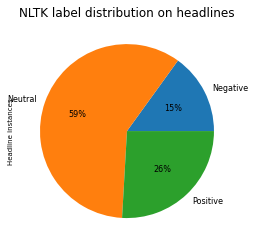

In [201]:
def label_function(val):
    return f'{val:.0f}%'

df_sub.groupby('NLTK_label').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 8},
#                                 colors=['tomato', 'gold', 'skyblue'],
                                title='NLTK label distribution on headlines'
                               )

plt.ylabel('Headline instances', size=7);

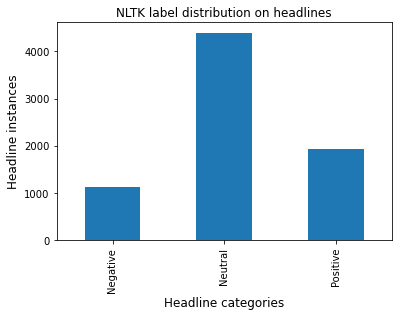

In [202]:
df_sub.groupby('NLTK_label').size().plot(kind='bar',
                                    title='NLTK label distribution on headlines'
                                   )

plt.ylabel('Headline instances', size=12)
plt.xlabel('Headline categories', size=12);

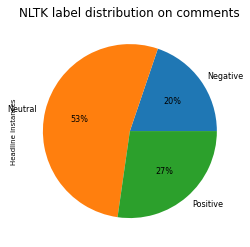

In [203]:
def label_function(val):
    return f'{val:.0f}%'

df_com.groupby('NLTK_label').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 8},
#                                 colors=['tomato', 'gold', 'skyblue'],
                                title='NLTK label distribution on comments'
                               )

plt.ylabel('Headline instances', size=7);

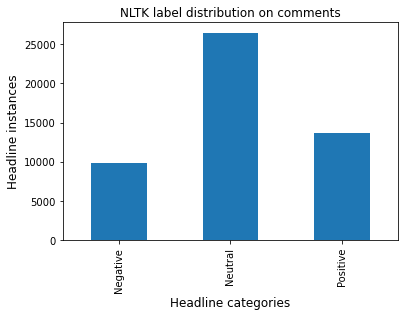

In [204]:
df_com.groupby('NLTK_label').size().plot(kind='bar',
                                    title='NLTK label distribution on comments'
                                   )

plt.ylabel('Headline instances', size=12)
plt.xlabel('Headline categories', size=12);

# Save updated dataframes
List columns not needed any more

In [ ]:
df_sub.drop(['list', 'merged_list'], axis=1, inplace=True)
df_com.drop(['list', 'merged_list'], axis=1, inplace=True)

In [117]:
output_posts = r'C:\Users\Panagiotis.Mavritsak\Desktop\Reddit sentiment analysis\downloaded data\summaries\posts\\'
df_sub.to_csv(output_posts+'UpdatedSubmissions.csv', 
                      index=False
                     )

In [118]:
output_comments = r'C:\Users\Panagiotis.Mavritsak\Desktop\Reddit sentiment analysis\downloaded data\summaries\comments\\'
df_com.to_csv(output_comments+'UpdatedComments.csv', 
                   index=False
                  )